In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.serialization
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import copy
import os
import seaborn as sns

In [2]:
class F1RaceDataset(Dataset):
    def __init__(self, features, targets, numerical_cols, categorical_cols, scaler=None, pitstop_scaler=None):
        """
        Args:
            features (pd.DataFrame): Feature data
            targets (pd.DataFrame): Target data
            numerical_cols (list): Names of numerical columns
            categorical_cols (list): Names of categorical columns
            scaler (StandardScaler, optional): Pre-fitted scaler for numerical features
            pitstop_scaler (StandardScaler, optional): Pre-fitted scaler for pitstop laps
        """
        self.features = features
        self.targets = targets
        self.numerical_cols = numerical_cols
        self.categorical_cols = categorical_cols
        
        # Constants for padding
        self.MAX_PITSTOPS = 7
        self.MAX_TYRES = 8
        self.NUM_TYRE_CLASSES = 8
        
        # Scale numerical features using provided or new scaler
        if scaler is None:
            self.scaler = StandardScaler()
            scaled_features = self.scaler.fit_transform(self.features[numerical_cols])
        else:
            self.scaler = scaler
            scaled_features = self.scaler.transform(self.features[numerical_cols])
        
        # Process list features
        pitstop_laps, pitstop_masks = self._process_pitstop_laps()
        
        # Scale pit stop laps using provided or new scaler
        if pitstop_scaler is None:
            self.pitstop_scaler = StandardScaler()
            valid_laps = pitstop_laps[pitstop_masks]
            if len(valid_laps) > 0:
                valid_laps_reshaped = valid_laps.reshape(-1, 1)
                self.pitstop_scaler.fit(valid_laps_reshaped)
                pitstop_laps_reshaped = pitstop_laps.reshape(-1, 1)
                scaled_pitstop_laps = self.pitstop_scaler.transform(pitstop_laps_reshaped)
                pitstop_laps = scaled_pitstop_laps.reshape(pitstop_laps.shape)
        else:
            self.pitstop_scaler = pitstop_scaler
            pitstop_laps_reshaped = pitstop_laps.reshape(-1, 1)
            scaled_pitstop_laps = self.pitstop_scaler.transform(pitstop_laps_reshaped)
            pitstop_laps = scaled_pitstop_laps.reshape(pitstop_laps.shape)
            
        tyre_compounds, tyre_masks = self._process_tyre_compounds()
        
        # Convert to tensors
        self.numerical_features = torch.FloatTensor(scaled_features)
        self.categorical_features = torch.LongTensor(self.features[categorical_cols].values)
        self.pitstop_laps = torch.FloatTensor(pitstop_laps)  # Changed to FloatTensor since we're scaling
        self.pitstop_masks = torch.BoolTensor(pitstop_masks)
        self.tyre_compounds = torch.LongTensor(tyre_compounds)
        self.tyre_masks = torch.BoolTensor(tyre_masks)
        self.targets = torch.FloatTensor(self.targets.values)
    
    def _process_pitstop_laps(self):
        """Process PitStopLaps lists with padding"""
        pit_lists = self.features['PitStopLaps'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        
        padded_data = np.zeros((len(pit_lists), self.MAX_PITSTOPS), dtype=np.float64)  # Changed to float64
        masks = np.zeros((len(pit_lists), self.MAX_PITSTOPS), dtype=bool)
        
        for i, pit_list in enumerate(pit_lists):
            if isinstance(pit_list, list) and len(pit_list) > 0:
                length = min(len(pit_list), self.MAX_PITSTOPS)
                padded_data[i, :length] = pit_list[:length]
                masks[i, :length] = True
        
        return padded_data, masks
    
    def _process_tyre_compounds(self):
        """Process TyreCompounds_encoded lists with padding"""
        tyre_lists = self.features['TyreCompounds_encoded'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        
        padded_data = np.zeros((len(tyre_lists), self.MAX_TYRES), dtype=np.int64)
        masks = np.zeros((len(tyre_lists), self.MAX_TYRES), dtype=bool)
        
        for i, tyre_list in enumerate(tyre_lists):
            if isinstance(tyre_list, list) and len(tyre_list) > 0:
                length = min(len(tyre_list), self.MAX_TYRES)
                padded_data[i, :length] = tyre_list[:length]
                masks[i, :length] = True
        
        return padded_data, masks
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return {
            'numerical_features': self.numerical_features[idx],
            'categorical_features': self.categorical_features[idx],
            'pitstop_laps': self.pitstop_laps[idx],
            'pitstop_masks': self.pitstop_masks[idx],
            'tyre_compounds': self.tyre_compounds[idx],
            'tyre_masks': self.tyre_masks[idx],
            'target': self.targets[idx]
        }

In [3]:
class MixupF1Dataset(Dataset):
    def __init__(self, base_dataset, alpha=0.2):
        self.base_dataset = base_dataset
        self.alpha = alpha
        
    def __len__(self):
        return len(self.base_dataset)
        
    def __getitem__(self, idx):
        # Get first sample
        sample1 = self.base_dataset[idx]
        
        # Randomly select second sample
        idx2 = random.randint(0, len(self.base_dataset) - 1)
        sample2 = self.base_dataset[idx2]
        
        # Generate mixup weight from beta distribution
        if self.alpha > 0:
            lam = np.random.beta(self.alpha, self.alpha)
        else:
            lam = 1
            
        # Interpolate numerical features
        mixed_numerical = lam * sample1['numerical_features'] + (1 - lam) * sample2['numerical_features']
        
        # Keep categorical features from the dominant sample
        if lam > 0.5:
            dominant_sample = sample1
        else:
            dominant_sample = sample2
            
        return {
            'numerical_features': mixed_numerical,
            'categorical_features': dominant_sample['categorical_features'],
            'pitstop_laps': dominant_sample['pitstop_laps'],
            'pitstop_masks': dominant_sample['pitstop_masks'],
            'tyre_compounds': dominant_sample['tyre_compounds'],
            'tyre_masks': dominant_sample['tyre_masks'],
            'target': lam * sample1['target'] + (1 - lam) * sample2['target']
        }

def create_dataloaders(batch_size=64, train_size=0.6, val_size=0.2, 
                      random_state=42, use_mixup=False, mixup_alpha=0.2, use_stratified=True):
    """
    Create train, validation, and test dataloaders with stratified sampling
    """
    features = pd.read_csv('data/processed_features.csv')
    targets = pd.read_csv('data/processed_targets.csv')
    
    numerical_cols = ['Round', 'GridPosition', 'NumParticipants',
                 'AirTemp', 'Humidity', 'Pressure', 'TrackTemp',
                 'WindDirection', 'WindSpeed', 'Q1Time', 'Laps']

    categorical_cols = ['Season_encoded', 'Circuit_encoded', 'Team_encoded', 
                    'Driver_encoded', 'NumPitStops']
    
    # Create position change bins for stratification
    def create_position_bins(pos_changes):
        bins = [-float('inf'), -10, -5, -2, -1, 0, 1, 2, 5, 10, float('inf')]
        return pd.cut(pos_changes, bins=bins, labels=range(len(bins)-1))
    
    # Stratify based on binned position changes
    position_bins = create_position_bins(targets['ClassificationResult'])
    
    # First split: train and temp
    train_features, temp_features, train_targets, temp_targets = train_test_split(
        features,
        targets['ClassificationResult'],
        train_size=train_size,
        random_state=random_state,
        stratify=position_bins if use_stratified else None
    )
    
    # Second split: divide temp into val and test
    val_features, test_features, val_targets, test_targets = train_test_split(
        temp_features,
        temp_targets,
        train_size=val_size/(1-train_size),
        random_state=random_state,
        stratify=create_position_bins(temp_targets) if use_stratified else None
    )

    # Create and fit scalers on training data
    feature_scaler = StandardScaler()
    feature_scaler.fit(train_features[numerical_cols])
    
    # Create and fit pitstop scaler
    pit_lists = train_features['PitStopLaps'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    padded_data = np.zeros((len(pit_lists), 7), dtype=np.float64)
    masks = np.zeros((len(pit_lists), 7), dtype=bool)
    
    for i, pit_list in enumerate(pit_lists):
        if isinstance(pit_list, list) and len(pit_list) > 0:
            length = min(len(pit_list), 7)
            padded_data[i, :length] = pit_list[:length]
            masks[i, :length] = True
    
    valid_laps = padded_data[masks]
    pitstop_scaler = StandardScaler()
    if len(valid_laps) > 0:
        pitstop_scaler.fit(valid_laps.reshape(-1, 1))

    # Create base datasets
    train_dataset = F1RaceDataset(
        train_features,
        train_targets,
        numerical_cols,
        categorical_cols,
        scaler=feature_scaler,
        pitstop_scaler=pitstop_scaler
    )
    
    val_dataset = F1RaceDataset(
        val_features,
        val_targets,
        numerical_cols,
        categorical_cols,
        scaler=feature_scaler,
        pitstop_scaler=pitstop_scaler
    )
    
    test_dataset = F1RaceDataset(
        test_features,
        test_targets,
        numerical_cols,
        categorical_cols,
        scaler=feature_scaler,
        pitstop_scaler=pitstop_scaler
    )
    
    # Initialize the final training dataset
    final_train_dataset = train_dataset
    combined_targets = train_targets.values
    
    # Create weighted sampler for training data if using stratified sampling
    train_sampler = None
    if use_stratified:
        # Calculate class weights using combined targets
        train_bins = create_position_bins(pd.Series(combined_targets))
        class_counts = np.bincount(train_bins)
        class_weights = 1.0 / class_counts
        sample_weights = class_weights[train_bins]
        sample_weights = sample_weights / sample_weights.sum()
        
        train_sampler = WeightedRandomSampler(
            weights=torch.DoubleTensor(sample_weights),
            num_samples=len(combined_targets),
            replacement=True
        )
    
    # Apply mixup if required
    if use_mixup:
        final_train_dataset = MixupF1Dataset(final_train_dataset, alpha=mixup_alpha)
    
    # Create final dataloaders
    train_loader = DataLoader(
        final_train_dataset,
        batch_size=batch_size,
        sampler=train_sampler if use_stratified and not use_mixup else None,
        shuffle=(not use_stratified) and (train_sampler is None)
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    feature_dims = {
        'numerical_dim': len(numerical_cols),
        'categorical_dims': {
            'Season': len(features['Season_encoded'].unique()),
            'Circuit': len(features['Circuit_encoded'].unique()),
            'Team': len(features['Team_encoded'].unique()),
            'Driver': len(features['Driver_encoded'].unique()),
            'NumPitStops': 8,  # 0-7 possible pitstops
        },
        'embedding_dim': 32,
        'max_pitstops': 7,
        'max_tyres': 8,
        'num_tyre_classes': 8
    }
    
    return train_loader, val_loader, test_loader, feature_dims

In [4]:
# Create samble data loaders for printing to console
train_loader, val_loader, test_loader, feature_dims = create_dataloaders(
    batch_size=4
)

print("\nFeature dimensions:", feature_dims)
# Print number of samples in each loader
print("\nNumber of samples in each loader:")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")


print("\nFeature dimensions:", feature_dims)
# Get a batch from training data
print("\nExample batch from training data:")
for batch in train_loader:
    print("\nBatch shapes:")
    print("Numerical features shape:", batch['numerical_features'].shape)
    print("Categorical features shape:", batch['categorical_features'].shape)
    print("PitStop laps shape:", batch['pitstop_laps'].shape)
    print("PitStop masks shape:", batch['pitstop_masks'].shape)
    print("Tyre compounds shape:", batch['tyre_compounds'].shape)
    print("Tyre masks shape:", batch['tyre_masks'].shape)
    print("Target shape:", batch['target'].shape)
    
    # Print first sample details
    print("\n=== First Sample Details ===")
    
    print("\nNumerical features:")
    numerical_cols = ['Round', 'GridPosition', 'NumParticipants', 'NumPitStops',
                     'AirTemp', 'Humidity', 'Pressure', 'TrackTemp',
                     'WindDirection', 'WindSpeed', 'Q1Time', 'Laps']
    numerical_sample = batch['numerical_features'][0].cpu().numpy()
    for col, val in zip(numerical_cols, numerical_sample):
        print(f"{col}: {val:.4f}")
    
    print("\nCategorical features:")
    categorical_cols = ['Season_encoded', 'Circuit_encoded', 'Team_encoded', 
                   'Driver_encoded', 'NumPitStops']
    categorical_sample = batch['categorical_features'][0].cpu().numpy()
    for col, val in zip(categorical_cols, categorical_sample):
        print(f"{col}: {int(val)}")
    
    print("\nPitStop laps (with mask):")
    pitstop_laps = batch['pitstop_laps'][0].cpu().numpy()
    pitstop_masks = batch['pitstop_masks'][0].cpu().numpy()
    for i, (lap, mask) in enumerate(zip(pitstop_laps, pitstop_masks)):
        if mask:
            print(f"PitStop {i + 1}: Lap {lap}")
        else:
            print(f"PitStop {i + 1}: Padded (mask=False)")
    
    print("\nTyre compounds (with mask):")
    tyre_compounds = batch['tyre_compounds'][0].cpu().numpy()
    tyre_masks = batch['tyre_masks'][0].cpu().numpy()
    for i, (compound, mask) in enumerate(zip(tyre_compounds, tyre_masks)):
        if mask:
            print(f"Tyre {i + 1}: Compound {compound}")
        else:
            print(f"Tyre {i + 1}: Padded (mask=False)")
    
    print("\nTarget:", batch['target'][0].item())
    
    break  # Just print first batch


Feature dimensions: {'numerical_dim': 11, 'categorical_dims': {'Season': 7, 'Circuit': 34, 'Team': 18, 'Driver': 40, 'NumPitStops': 8}, 'embedding_dim': 32, 'max_pitstops': 7, 'max_tyres': 8, 'num_tyre_classes': 8}

Number of samples in each loader:
Training samples: 1437
Validation samples: 479
Test samples: 480

Feature dimensions: {'numerical_dim': 11, 'categorical_dims': {'Season': 7, 'Circuit': 34, 'Team': 18, 'Driver': 40, 'NumPitStops': 8}, 'embedding_dim': 32, 'max_pitstops': 7, 'max_tyres': 8, 'num_tyre_classes': 8}

Example batch from training data:

Batch shapes:
Numerical features shape: torch.Size([4, 11])
Categorical features shape: torch.Size([4, 5])
PitStop laps shape: torch.Size([4, 7])
PitStop masks shape: torch.Size([4, 7])
Tyre compounds shape: torch.Size([4, 8])
Tyre masks shape: torch.Size([4, 8])
Target shape: torch.Size([4])

=== First Sample Details ===

Numerical features:
Round: -0.6887
GridPosition: 0.0116
NumParticipants: 0.0794
NumPitStops: -0.6366
AirTem

In [5]:
class StrategyGeneratorNetwork(nn.Module):
    def __init__(self, numerical_dim, categorical_dims, embedding_dim=32):
        super().__init__()
        
        # Same embeddings as before...
        self.embeddings = nn.ModuleDict({
            'Season': nn.Sequential(
                nn.Embedding(categorical_dims['Season'], 32),
                nn.LayerNorm(32),
                nn.Dropout(0.1)
            ),
            'Circuit': nn.Sequential(
                nn.Embedding(categorical_dims['Circuit'], 64),
                nn.LayerNorm(64),
                nn.Dropout(0.1)
            ),
            'Team': nn.Sequential(
                nn.Embedding(categorical_dims['Team'], 48),
                nn.LayerNorm(48),
                nn.Dropout(0.1)
            ),
            'Driver': nn.Sequential(
                nn.Embedding(categorical_dims['Driver'], 48),
                nn.LayerNorm(48),
                nn.Dropout(0.1)
            )
        })
        
        # Numerical encoder
        self.numerical_encoder = nn.Sequential(
            nn.Linear(numerical_dim, 192),
            nn.LayerNorm(192),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # Feature combination layer
        self.feature_combiner = nn.Linear(384, 192)  # Combine numerical + categorical
        
        # Strategy heads
        self.stops_head = nn.Sequential(
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 7)  # 0-6 stops
        )
        
        self.timing_head = nn.Sequential(
            nn.Linear(192, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 7),
            nn.Sigmoid()  # Normalize to [0,1]
        )
        
        self.compound_head = nn.Sequential(
            nn.Linear(192, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 8)  # 8 compounds
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Custom weight initialization"""
        for name, module in self.named_modules():
            if isinstance(module, nn.Embedding):
                nn.init.trunc_normal_(module.weight, mean=0.0, std=0.02, a=-0.04, b=0.04)
            elif isinstance(module, nn.Linear):
                if 'head' in name:
                    nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='linear')
                    module.weight.data *= 0.1
                else:
                    nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                
                if module.bias is not None:
                    if 'stops_head' in name and module.bias.shape[0] == 7:
                        module.bias.data = torch.tensor([
                    0.994,   # 1 stop (reduced preference)
                    1.0,   # 2 stops (closer to 1-stop)
                    0.98,   # 3 stops (more viable)
                    -0.3,  # 4 stops (less penalty)
                    -0.8,  # 5 stops
                    -0.8,  # 6 stops
                    -0.8   # 7 stops
                ])
                    elif 'compound_head' in name and module.bias.shape[0] == 8:
                        module.bias.data = torch.tensor([
                    0.03,   # HARD (increased)
                    0.0,  # HYPERSOFT
                    0.0,   # INTERMEDIATE
                    0.04,   # MEDIUM (reduced)
                    0.06001,   # SOFT (closer to MEDIUM)
                    0.0,   # SUPERSOFT
                    -0.2,   # ULTRASOFT
                    -0.5   # WET
                ])
                    else:
                        nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
    
    def forward(self, numerical_features, categorical_features):
        # Process numerical features
        numerical_encoded = self.numerical_encoder(numerical_features)  # [batch_size, 192]
        
        # Process categorical features
        embedded = []
        for i, (name, embedding) in enumerate(self.embeddings.items()):
            embedded.append(embedding(categorical_features[:, i]))
        categorical_encoded = torch.cat(embedded, dim=1)  # [batch_size, 192]
        
        # Combine features
        combined = torch.cat([numerical_encoded, categorical_encoded], dim=1)  # [batch_size, 384]
        features = self.feature_combiner(combined)  # [batch_size, 192]
        
        # Generate outputs
        return {
            'num_pitstops_prob': self.stops_head(features),
            'pitstop_laps_relative': self.timing_head(features),
            'tyre_compounds_prob': self.compound_head(features)
        }

In [6]:
class F1_Pos_Pred(nn.Module):
    def __init__(self, numerical_dim, categorical_dims, max_pitstops=7, max_tyres=8, num_tyre_classes=8):
        super().__init__()
        
        self.embedding_dims = {
            'Season': 48,
            'Circuit': 96,
            'Team': 64,
            'Driver': 96,
            'NumPitStops': 32, 
        }
        
        # Embeddings with dropout
        self.embeddings = nn.ModuleDict({
            name: nn.Sequential(
                nn.Embedding(categorical_dims[name], dim),
                nn.Dropout(0.5)
            )
            for name, dim in self.embedding_dims.items()
        })
        
        # Tire embedding
        self.tyre_embedding = nn.Sequential(
            nn.Embedding(num_tyre_classes, 48), 
            nn.Dropout(0.5)
        )
        
        total_embedding_dim = sum(self.embedding_dims.values())
        combined_input_dim = numerical_dim + total_embedding_dim
        
        # Hidden dimensions
        pitstop_hidden_dim = 128
        tyre_hidden_dim = 128
        
        # Normalization for numerical features
        self.numerical_bn = nn.BatchNorm1d(numerical_dim)
        
        # LSTM for pitstops with bidirectional
        self.pitstop_lstm = nn.LSTM(
            input_size=1,
            hidden_size=pitstop_hidden_dim // 2,  # Half size because bidirectional
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )
        
        # LSTM for tires with bidirectional
        self.tyre_lstm = nn.LSTM(
            input_size=48,  
            hidden_size=tyre_hidden_dim // 2,  # Half size because bidirectional
            num_layers=2,
            batch_first=True,
            dropout=0.5,
            bidirectional=True
        )
        
        # Attention mechanisms
        self.pitstop_attention = nn.MultiheadAttention(pitstop_hidden_dim, 4, dropout=0.1)
        self.tyre_attention = nn.MultiheadAttention(tyre_hidden_dim, 4, dropout=0.1)
        
        # Feature processing with residual connections
        self.combined_features_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(combined_input_dim if i == 0 else 512, 512),
                nn.ReLU(),
                nn.LayerNorm(512),
                nn.Dropout(0.5)
            ) for i in range(3)
        ])
        
        # Final wide layers layers with residual connections
        final_input_dim = 512 + pitstop_hidden_dim + tyre_hidden_dim
        self.final_layers = nn.Sequential(
            nn.Linear(final_input_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.LayerNorm(128),
            nn.Linear(128, 1)
        )
        
        self._init_weights()
        self.l2_lambda = 0.0005
        
    def _init_weights(self):
        """Weight initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
            elif isinstance(module, (nn.BatchNorm1d, nn.LayerNorm)):
                nn.init.constant_(module.weight, 1.0)
                nn.init.constant_(module.bias, 0)
    
    def _apply_attention(self, sequence, attention_layer):
        """Apply attention mechanism to sequence"""
        # Reshape for attention: [batch, seq_len, hidden] -> [seq_len, batch, hidden]
        sequence = sequence.transpose(0, 1)
        attended, _ = attention_layer(sequence, sequence, sequence)
        # Reshape back: [seq_len, batch, hidden] -> [batch, seq_len, hidden]
        return attended.transpose(0, 1)
    
    def _process_sequence_with_mask(self, sequence, mask, lstm):
        """Sequence processing with attention"""
        # Get sequence lengths from mask
        lengths = mask.sum(dim=1)
        batch_size = sequence.size(0)
        hidden_size = lstm.hidden_size * 2  # *2 for bidirectional
        
        # Handle empty sequences
        if lengths.max() == 0:
            return torch.zeros(batch_size, hidden_size, device=sequence.device)
        
        # Ensure minimum length of 1
        lengths = torch.max(lengths, torch.ones_like(lengths))
        
        # Pack sequence
        packed_sequence = nn.utils.rnn.pack_padded_sequence(
            sequence,
            lengths.cpu(),
            batch_first=True,
            enforce_sorted=False
        )
        
        # Process through LSTM
        _, (hidden, _) = lstm(packed_sequence)
        
        # Concatenate forward and backward hidden states
        hidden_states = torch.cat([hidden[-2], hidden[-1]], dim=1)
        
        # Handle empty sequences
        zero_length_mask = (mask.sum(dim=1) == 0).unsqueeze(1)
        hidden_states = torch.where(
            zero_length_mask,
            torch.zeros_like(hidden_states),
            hidden_states
        )
        
        return hidden_states
    
    def forward(self, numerical_features, categorical_features, 
                pitstop_laps, pitstop_masks, tyre_compounds, tyre_masks):
        """Forward pass with residual connections and attention"""
        # Normalize numerical features
        numerical_features = self.numerical_bn(numerical_features)
        
        # Process categorical features
        embedded_features = []
        for i, (name, embedding_layer) in enumerate(self.embeddings.items()):
            max_idx = embedding_layer[0].num_embeddings - 1
            current_indices = categorical_features[:, i]
            if torch.max(current_indices) > max_idx:
                raise ValueError(f"Index out of bounds for {name}")
            embedded = embedding_layer(current_indices)
            embedded_features.append(embedded)
        
        categorical_input = torch.cat(embedded_features, dim=1)
        
        # Combine features
        combined_features = torch.cat([numerical_features, categorical_input], dim=1)
        
        # Process combined features with residual connections
        x = combined_features
        for layer in self.combined_features_layers:
            x = layer(x) + x if x.size() == layer(x).size() else layer(x)
        combined_features_out = x
        
        # Process sequences
        pitstop_laps = pitstop_laps.float().unsqueeze(-1)
        pitstop_hidden = self._process_sequence_with_mask(
            pitstop_laps,
            pitstop_masks,
            self.pitstop_lstm
        )
        
        tyre_embedded = self.tyre_embedding(tyre_compounds)
        tyre_hidden = self._process_sequence_with_mask(
            tyre_embedded,
            tyre_masks,
            self.tyre_lstm
        )
        
        # Combine features
        final_combined = torch.cat([
            combined_features_out,
            pitstop_hidden,
            tyre_hidden
        ], dim=1)
        
        # Final prediction
        output = self.final_layers(final_combined)
        
        return output.squeeze()
    
    def get_l2_regularization(self):
        """Calculate L2 regularization with lambda"""
        l2_reg = 0.0
        for param in self.parameters():
            l2_reg += torch.norm(param, 2)
        return self.l2_lambda * l2_reg

In [7]:
def get_features_without_strategy(batch):
    """Get base features by removing strategy-related features"""
    return {
        'numerical_features': batch['numerical_features'],
        'categorical_features': batch['categorical_features'][:, :-1]  # Remove NumPitStops from categorical features
    }

def load_position_model(device):
    """
    Load the position model with its configuration
    
    Args:
        device: Torch device to load the model on
    
    Returns:
        Loaded model and its configuration
    """
    try:
        # Load the entire save dictionary
        checkpoint = torch.load('checkpoints/f1_position_model.pth', map_location=device)
        
        # Extract model configuration
        model_config = checkpoint['model_config']
        feature_dims = checkpoint['feature_dims']
        
        # Recreate the model with the same configuration
        position_model = F1_Pos_Pred(
            numerical_dim=feature_dims['numerical_dim'],
            categorical_dims=feature_dims['categorical_dims'],
            max_pitstops=feature_dims['max_pitstops'],
            max_tyres=feature_dims['max_tyres'],
            num_tyre_classes=feature_dims['num_tyre_classes']
        ).to(device)
    
        # Load the state dictionary
        position_model.load_state_dict(checkpoint['model_state_dict'])
        
        # Set the model to evaluation mode
        position_model.eval()
        
        return position_model, model_config
    
    except Exception as e:
        raise RuntimeError(f"Failed to load position model: {str(e)}")

def create_model(feature_dims, device):
    """Create strategy model and load position model with safe loading"""
    # Load position model
    position_model, _ = load_position_model(device)
    
    # Print dimensions for debugging
    print(f"Position model expects numerical_dim: {feature_dims['numerical_dim']}")
    
    # Create strategy model with same dimensions as position model
    strategy_model = StrategyGeneratorNetwork(
        numerical_dim=feature_dims['numerical_dim'],  # Don't subtract 1
        categorical_dims=feature_dims['categorical_dims'],
        embedding_dim=feature_dims['embedding_dim']
    ).to(device)
    
    return strategy_model, position_model

In [8]:
class StrategyLoss(nn.Module):
    def __init__(self, position_model, device):
        super().__init__()
        self.position_model = position_model
        self.device = device
        
        # Freeze position model
        self.position_model.eval()
        for param in self.position_model.parameters():
            param.requires_grad = False
            
        # Strategy constraints
        self.min_stint_length = 1  # Minimum laps per stint
        self.max_stint_length = 70  # Maximum laps per stint
        self.stint_length_weight = 0.3
        self.tire_diversity_weight = 0.2
        self.strategy_weights = {
            'position': 1.0,
            'stint_length': 0.3,
            'tire_diversity': 0.2,
            'pit_timing': 0.2
        }
    
    def _compute_stint_lengths(self, strategy_outputs, batch):
        batch_size = strategy_outputs['num_pitstops_prob'].size(0)
        total_laps = batch['numerical_features'][:, -1]
        
        pit_probs = F.gumbel_softmax(strategy_outputs['num_pitstops_prob'], tau=0.5, hard=False)
        n_stops = torch.argmax(pit_probs, dim=1)
        
        stint_lengths = []
        for i in range(batch_size):
            if n_stops[i] == 0:
                stint_lengths.append(total_laps[i].unsqueeze(0))
            else:
                laps = strategy_outputs['pitstop_laps_relative'][i, :n_stops[i]] * total_laps[i]
                laps = torch.sort(laps)[0]  # Sort pit stop laps
                
                # Calculate stint lengths
                lengths = torch.zeros(n_stops[i] + 1, device=self.device)
                lengths[0] = laps[0]  # First stint
                lengths[1:-1] = laps[1:] - laps[:-1]  # Middle stints
                lengths[-1] = total_laps[i] - laps[-1]  # Last stint
                
                stint_lengths.append(lengths)
        
        return torch.cat(stint_lengths)
    
    def _compute_tire_diversity_loss(self, strategy_outputs):
        tire_probs = F.gumbel_softmax(strategy_outputs['tyre_compounds_prob'], tau=0.5, hard=False)
        
        # Penalize using the same tire compound too much
        compound_usage = tire_probs.mean(dim=0)  # Average usage per compound
        diversity_loss = -torch.sum(compound_usage * torch.log(compound_usage + 1e-10))
        
        return diversity_loss
    
    def _compute_pit_timing_loss(self, strategy_outputs, batch):
        batch_size = strategy_outputs['num_pitstops_prob'].size(0)
        total_laps = batch['numerical_features'][:, -1]
        
        pit_probs = F.gumbel_softmax(strategy_outputs['num_pitstops_prob'], tau=0.5, hard=False)
        n_stops = torch.argmax(pit_probs, dim=1)
        
        timing_loss = torch.tensor(0.0, device=self.device)
        count = 0
        
        for i in range(batch_size):
            if n_stops[i] > 0:
                # Get pit stop timings
                laps = strategy_outputs['pitstop_laps_relative'][i, :n_stops[i]] * total_laps[i]
                laps = torch.sort(laps)[0]
                
                # Penalize pit stops too close to start/end
                early_pit = torch.relu(15 - laps[0])  # Penalize stops before lap 15
                late_pit = torch.relu(laps[-1] - (total_laps[i] - 15))  # Penalize stops in last 15 laps
                
                # Penalize consecutive stops too close together
                if n_stops[i] > 1:
                    gaps = laps[1:] - laps[:-1]
                    close_stops = torch.relu(10 - gaps)  # Penalize gaps shorter than 10 laps
                    timing_loss += (early_pit + late_pit + close_stops.sum())
                    count += 1
        
        return timing_loss / max(count, 1)
    
    def forward(self, strategy_outputs, batch):
        batch_size = strategy_outputs['num_pitstops_prob'].size(0)
        
        # Get position prediction from frozen model
        position_input = self.convert_strategy_to_features(strategy_outputs, batch)
        with torch.no_grad():
            position_change = self.position_model(**position_input)
        
        # Compute strategy realism losses
        stint_lengths = self._compute_stint_lengths(strategy_outputs, batch)
        stint_length_loss = torch.mean(
            torch.relu(self.min_stint_length - stint_lengths) + 
            torch.relu(stint_lengths - self.max_stint_length)
        )
        
        tire_diversity_loss = self._compute_tire_diversity_loss(strategy_outputs)
        pit_timing_loss = self._compute_pit_timing_loss(strategy_outputs, batch)
        
        # Combine losses with weights
        total_loss = (
            -self.strategy_weights['position'] * torch.mean(position_change) +
            self.strategy_weights['stint_length'] * stint_length_loss +
            self.strategy_weights['tire_diversity'] * tire_diversity_loss +
            self.strategy_weights['pit_timing'] * pit_timing_loss
        )
        
        metrics = {
            'total_loss': float(total_loss.item()),
            'position_change': float(-torch.mean(position_change).item()),
            'stint_length_loss': float(stint_length_loss.item()),
            'tire_diversity_loss': float(tire_diversity_loss.item()),
            'pit_timing_loss': float(pit_timing_loss.item())
        }
        
        return total_loss, metrics

    def convert_strategy_to_features(self, strategy_outputs, batch):
        batch_size = strategy_outputs['num_pitstops_prob'].size(0)
        total_laps = batch['numerical_features'][:, -1]
        
        # Get number of stops
        num_pitstops = torch.argmax(
            F.gumbel_softmax(strategy_outputs['num_pitstops_prob'], tau=0.5, hard=True),
            dim=1
        )
        
        # Initialize tensors
        pitstop_laps = torch.zeros((batch_size, 7), device=self.device)
        pitstop_masks = torch.zeros((batch_size, 7), dtype=torch.bool, device=self.device)
        tyre_masks = torch.zeros((batch_size, 8), dtype=torch.bool, device=self.device)
        tyre_compounds = torch.zeros((batch_size, 8), dtype=torch.long, device=self.device)
        
        # Process each batch item
        for i in range(batch_size):
            n_stops = num_pitstops[i]
            if n_stops > 0:
                # Get pit stop timings
                rel_times = strategy_outputs['pitstop_laps_relative'][i, :n_stops]
                actual_laps = (rel_times * total_laps[i]).round()
                pitstop_laps[i, :n_stops] = actual_laps
                pitstop_masks[i, :n_stops] = True
                
                # Generate tire compounds for each stint
                stint_compounds = F.gumbel_softmax(
                    strategy_outputs['tyre_compounds_prob'][i:i+1].expand(n_stops+1, -1),
                    tau=0.5,
                    hard=True
                )
                tyre_compounds[i, :n_stops+1] = torch.argmax(stint_compounds, dim=1)
                tyre_masks[i, :n_stops+1] = True

        return {
            'numerical_features': batch['numerical_features'],
            'categorical_features': batch['categorical_features'],
            'pitstop_laps': pitstop_laps,
            'pitstop_masks': pitstop_masks,
            'tyre_compounds': tyre_compounds,
            'tyre_masks': tyre_masks
        }

In [9]:
def train_model(strategy_model, position_model, train_loader, val_loader, optimizer,
                scheduler, device, num_epochs):
    """Training loop with stability fixes"""
    criterion = StrategyLoss(position_model, device)
    best_position_gain = float('-inf')
    best_epoch = 0
    train_losses = []
    val_losses = []
    position_gains = []
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Training phase
        strategy_model.train()
        epoch_train_losses = []
        epoch_train_gains = []
        
        for batch_idx, batch in enumerate(train_loader):
            try:
                batch = {k: v.to(device) for k, v in batch.items()}
                base_features = get_features_without_strategy(batch)
                
                # Generate strategy
                strategy_outputs = strategy_model(
                    base_features['numerical_features'],
                    base_features['categorical_features']
                )
                
                # Compute loss
                loss, loss_components = criterion(strategy_outputs, batch)
                
                if torch.isfinite(loss).all():  # Only update if loss is valid
                    optimizer.zero_grad()
                    loss.backward()
                
                    optimizer.step()
                    
                    # Track metrics
                    epoch_train_losses.append(loss_components['total_loss'])
                    epoch_train_gains.append(loss_components['position_change'])
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {str(e)}")
                continue
        
        # Validation phase
        strategy_model.eval()
        epoch_val_losses = []
        epoch_val_gains = []
        
        with torch.no_grad():
            for batch in val_loader:
                try:
                    batch = {k: v.to(device) for k, v in batch.items()}
                    base_features = get_features_without_strategy(batch)
                    strategy_outputs = strategy_model(
                        base_features['numerical_features'],
                        base_features['categorical_features']
                    )
                    loss, loss_components = criterion(strategy_outputs, batch)
                    
                    if torch.isfinite(loss).all():
                        epoch_val_losses.append(loss_components['total_loss'])
                        epoch_val_gains.append(loss_components['position_change'])
                        
                except Exception as e:
                    print(f"Error in validation: {str(e)}")
                    continue
        
        # Calculate averages (safely)
        if epoch_train_losses:  # Only if we have valid losses
            train_loss = np.mean(epoch_train_losses)
            train_gain = np.mean(epoch_train_gains)
        else:
            train_loss = float('inf')
            train_gain = float('-inf')
            
        if epoch_val_losses:
            val_loss = np.mean(epoch_val_losses)
            val_gain = np.mean(epoch_val_gains)
        else:
            val_loss = float('inf')
            val_gain = float('-inf')
        
        # Record history
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        position_gains.append(val_gain)
        
        # Update learning rate (safely)
        if torch.isfinite(torch.tensor(val_loss)):
            scheduler.step()
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = float('nan')
        
        # Early stopping based on position gain
        if val_gain > best_position_gain and torch.isfinite(torch.tensor(val_gain)):
            best_position_gain = val_gain
            best_epoch = epoch + 1
            best_model_state = copy.deepcopy(strategy_model.state_dict())
        
        # Print metrics (only if they're valid)
        if (epoch + 1) % 1 == 0:
            print(f"\nEpoch {epoch+1}/{num_epochs} ({time.time() - start_time:.1f}s)")
            print(f"Train - Loss: {train_loss:.4f}, Gain: {train_gain:+.2f}")
            print(f"Val   - Loss: {val_loss:.4f}, Gain: {val_gain:+.2f}")
            print(f"Learning Rate: {current_lr:.6f}")
        
    # Restore best model
    strategy_model.load_state_dict(best_model_state)
    
    return {
        'best_position_gain': best_position_gain,
        'best_epoch': best_epoch,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'position_gains': position_gains
    }

In [10]:
def save_strategy_model(model, feature_dims, metrics, save_path='checkpoints/f1_strategy_model'):
    """Save the trained strategy generator model"""
    save_dict = {
        'model_state_dict': model.state_dict(),
        'feature_dims': feature_dims,
        'metrics': metrics,
        'model_config': {
            'numerical_dim': feature_dims['numerical_dim'],
            'categorical_dims': feature_dims['categorical_dims'],
            'embedding_dim': feature_dims['embedding_dim']
        }
    }
    
    torch.save(save_dict, f'{save_path}.pth')
    print(f"\nModel saved to {save_path}.pth")
    
    print("\nSaved model information:")
    print(f"Best validation loss: {metrics['best_val_loss']:.4f}")
    print(f"Best epoch: {metrics['best_epoch']}")

Using device: cuda

Dataset sizes:
Training samples: 1437
Validation samples: 479
Test samples: 480
Position model expects numerical_dim: 11

Models initialized


C:\Users\Eran Cohen\AppData\Local\Temp\ipykernel_6900\3720941550.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoints/f1_position_model.


Training Configuration:
Number of epochs: 30
Steps per epoch: 23
Total steps: 690
Initial learning rate: 1.00e-04
Max learning rate: 2e-4
Batch size: 64
Weight decay: 0.05

Epoch 1/30 (4.0s)
Train - Loss: 9.8579, Gain: -1.00
Val   - Loss: 10.2366, Gain: -0.54
Learning Rate: 0.000100

Epoch 2/30 (4.8s)
Train - Loss: 9.7994, Gain: -0.84
Val   - Loss: 10.5647, Gain: -0.39
Learning Rate: 0.000100

Epoch 3/30 (5.6s)
Train - Loss: 9.8715, Gain: -0.82
Val   - Loss: 10.0968, Gain: -0.42
Learning Rate: 0.000099

Epoch 4/30 (5.8s)
Train - Loss: 9.6967, Gain: -0.74
Val   - Loss: 9.8050, Gain: -0.47
Learning Rate: 0.000098

Epoch 5/30 (5.5s)
Train - Loss: 9.5932, Gain: -0.78
Val   - Loss: 10.2077, Gain: -0.52
Learning Rate: 0.000098

Epoch 6/30 (5.7s)
Train - Loss: 9.4931, Gain: -0.80
Val   - Loss: 9.6314, Gain: -0.56
Learning Rate: 0.000097

Epoch 7/30 (5.7s)
Train - Loss: 9.5875, Gain: -0.79
Val   - Loss: 9.6522, Gain: -0.53
Learning Rate: 0.000095

Epoch 8/30 (5.7s)
Train - Loss: 9.3432, Gain:

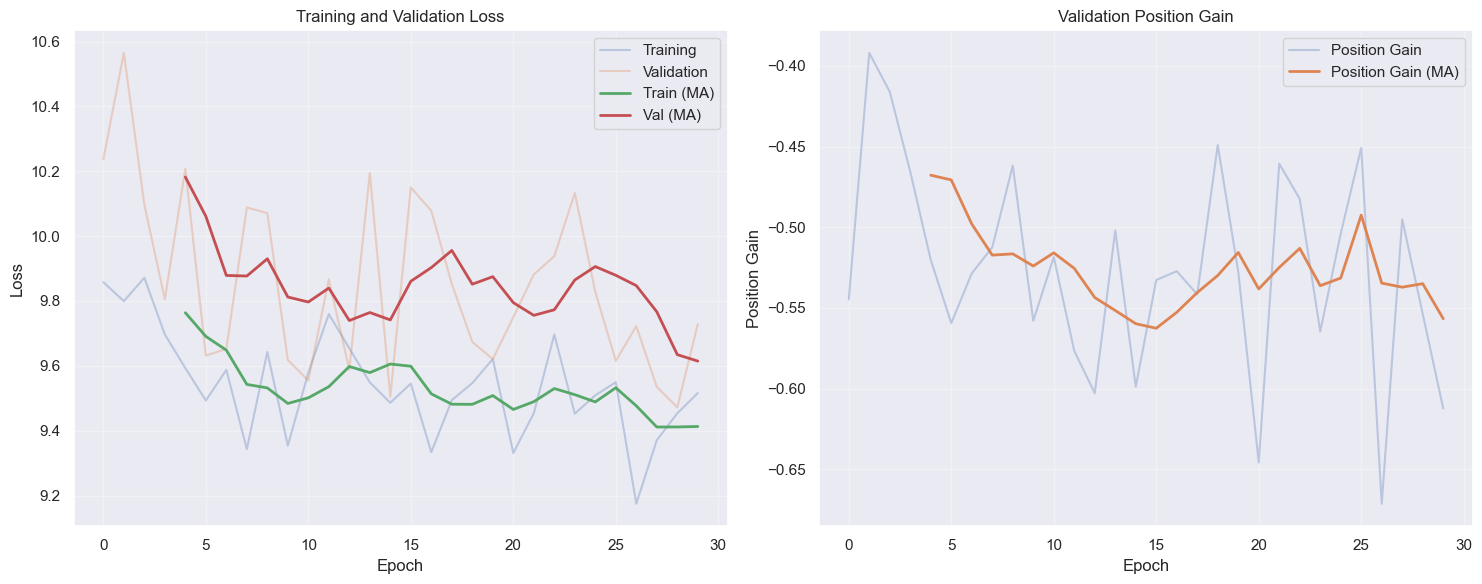


Training Summary:
Best position gain: -0.3920
Best epoch: 2
Final learning rate: 3.52e-05


In [11]:
# Set up device and reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)
print(f"Using device: {device}")

# Create dataloaders with more stable parameters
train_loader, val_loader, test_loader, feature_dims = create_dataloaders(
    batch_size=64,
    use_mixup=True,
    mixup_alpha=0.4,
    use_stratified=True
)

print("\nDataset sizes:")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Create and verify models
strategy_model, position_model = create_model(feature_dims, device)
print("\nModels initialized")

# Ensure position model is frozen
position_model.eval()
for param in position_model.parameters():
    param.requires_grad = False

# Training parameters
num_epochs = 30
steps_per_epoch = len(train_loader)
total_steps = num_epochs * steps_per_epoch

# Increase exploration
optimizer = torch.optim.AdamW(
    strategy_model.parameters(),
    lr=1e-4,  # Slightly higher initial learning rate
    weight_decay=0.05,  # Increased weight decay
    betas=(0.85, 0.999)  # More aggressive beta values
)

# Cyclic learning rate for better exploration
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=50,  # Initial restart cycle
    T_mult=2,  # Exponential increase in restart cycle
    eta_min=1e-6  # Minimum learning rate
)


print("\nTraining Configuration:")
print(f"Number of epochs: {num_epochs}")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Total steps: {total_steps}")
print(f"Initial learning rate: {optimizer.param_groups[0]['lr']:.2e}")
print(f"Max learning rate: 2e-4")
print(f"Batch size: {train_loader.batch_size}")
print(f"Weight decay: {optimizer.param_groups[0]['weight_decay']}")

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

# Train the model
metrics = train_model(
    strategy_model=strategy_model,
    position_model=position_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=num_epochs
)

# Save the trained model with detailed metadata
save_path = os.path.join('checkpoints', 'strategy_model_final.pth')
torch.save({
    'model_state_dict': strategy_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'metrics': metrics,
    'feature_dims': feature_dims,
    'config': {
        'num_epochs': num_epochs,
        'batch_size': train_loader.batch_size,
        'initial_lr': optimizer.param_groups[0]['lr'],
        'max_lr': 2e-4,
        'weight_decay': optimizer.param_groups[0]['weight_decay']
    }
}, save_path)

# Plot training history with enhanced visualization
sns.set_theme()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Loss plot with moving average
window_size = 5
train_ma = np.convolve(metrics['train_losses'], 
                      np.ones(window_size)/window_size, 
                      mode='valid')
val_ma = np.convolve(metrics['val_losses'], 
                    np.ones(window_size)/window_size, 
                    mode='valid')

ax1.plot(metrics['train_losses'], label='Training', alpha=0.3)
ax1.plot(metrics['val_losses'], label='Validation', alpha=0.3)
ax1.plot(range(window_size-1, len(metrics['train_losses'])), 
         train_ma, label='Train (MA)', linewidth=2)
ax1.plot(range(window_size-1, len(metrics['val_losses'])), 
         val_ma, label='Val (MA)', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Position Improvement plot with moving average
window_size = 5
train_pos_ma = np.convolve(metrics['position_gains'], 
                           np.ones(window_size)/window_size, 
                           mode='valid')

ax2.plot(metrics['position_gains'], label='Position Gain', alpha=0.3)
ax2.plot(range(window_size-1, len(metrics['position_gains'])), 
         train_pos_ma, label='Position Gain (MA)', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Position Gain')
ax2.set_title('Validation Position Gain')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics with more detail
print("\nTraining Summary:")
print(f"Best position gain: {metrics['best_position_gain']:.4f}")
print(f"Best epoch: {metrics['best_epoch']}")
print(f"Final learning rate: {optimizer.param_groups[0]['lr']:.2e}")

Testing strategy generator...

Strategy Generation Tests

Race 1
----------------------------------------
Starting Position: 17
Race Distance: 71 laps

Generated Strategy:
Number of Stops: 2
Complete Sequence:
Start: MEDIUM
Lap 36: MEDIUM

Actual Strategy:
Number of Stops: 2
Complete Sequence:
Start: MEDIUM
Lap 20: MEDIUM
Lap 43: HARD

Position Changes (positive means improvement):
Generated Strategy: 4
Actual Strategy:    3
True Outcome:       4

Final Positions:
Grid Position 17
Generated Strategy: 13
Actual Strategy:    14
True Outcome:       13
--------------------------------------------------------------------------------

Race 2
----------------------------------------
Starting Position: 3
Race Distance: 71 laps

Generated Strategy:
Number of Stops: 1
Complete Sequence:
Start: MEDIUM

Actual Strategy:
Number of Stops: 1
Complete Sequence:
Start: SOFT
Lap 23: MEDIUM

Position Changes (positive means improvement):
Generated Strategy: -3
Actual Strategy:    -2
True Outcome:       1

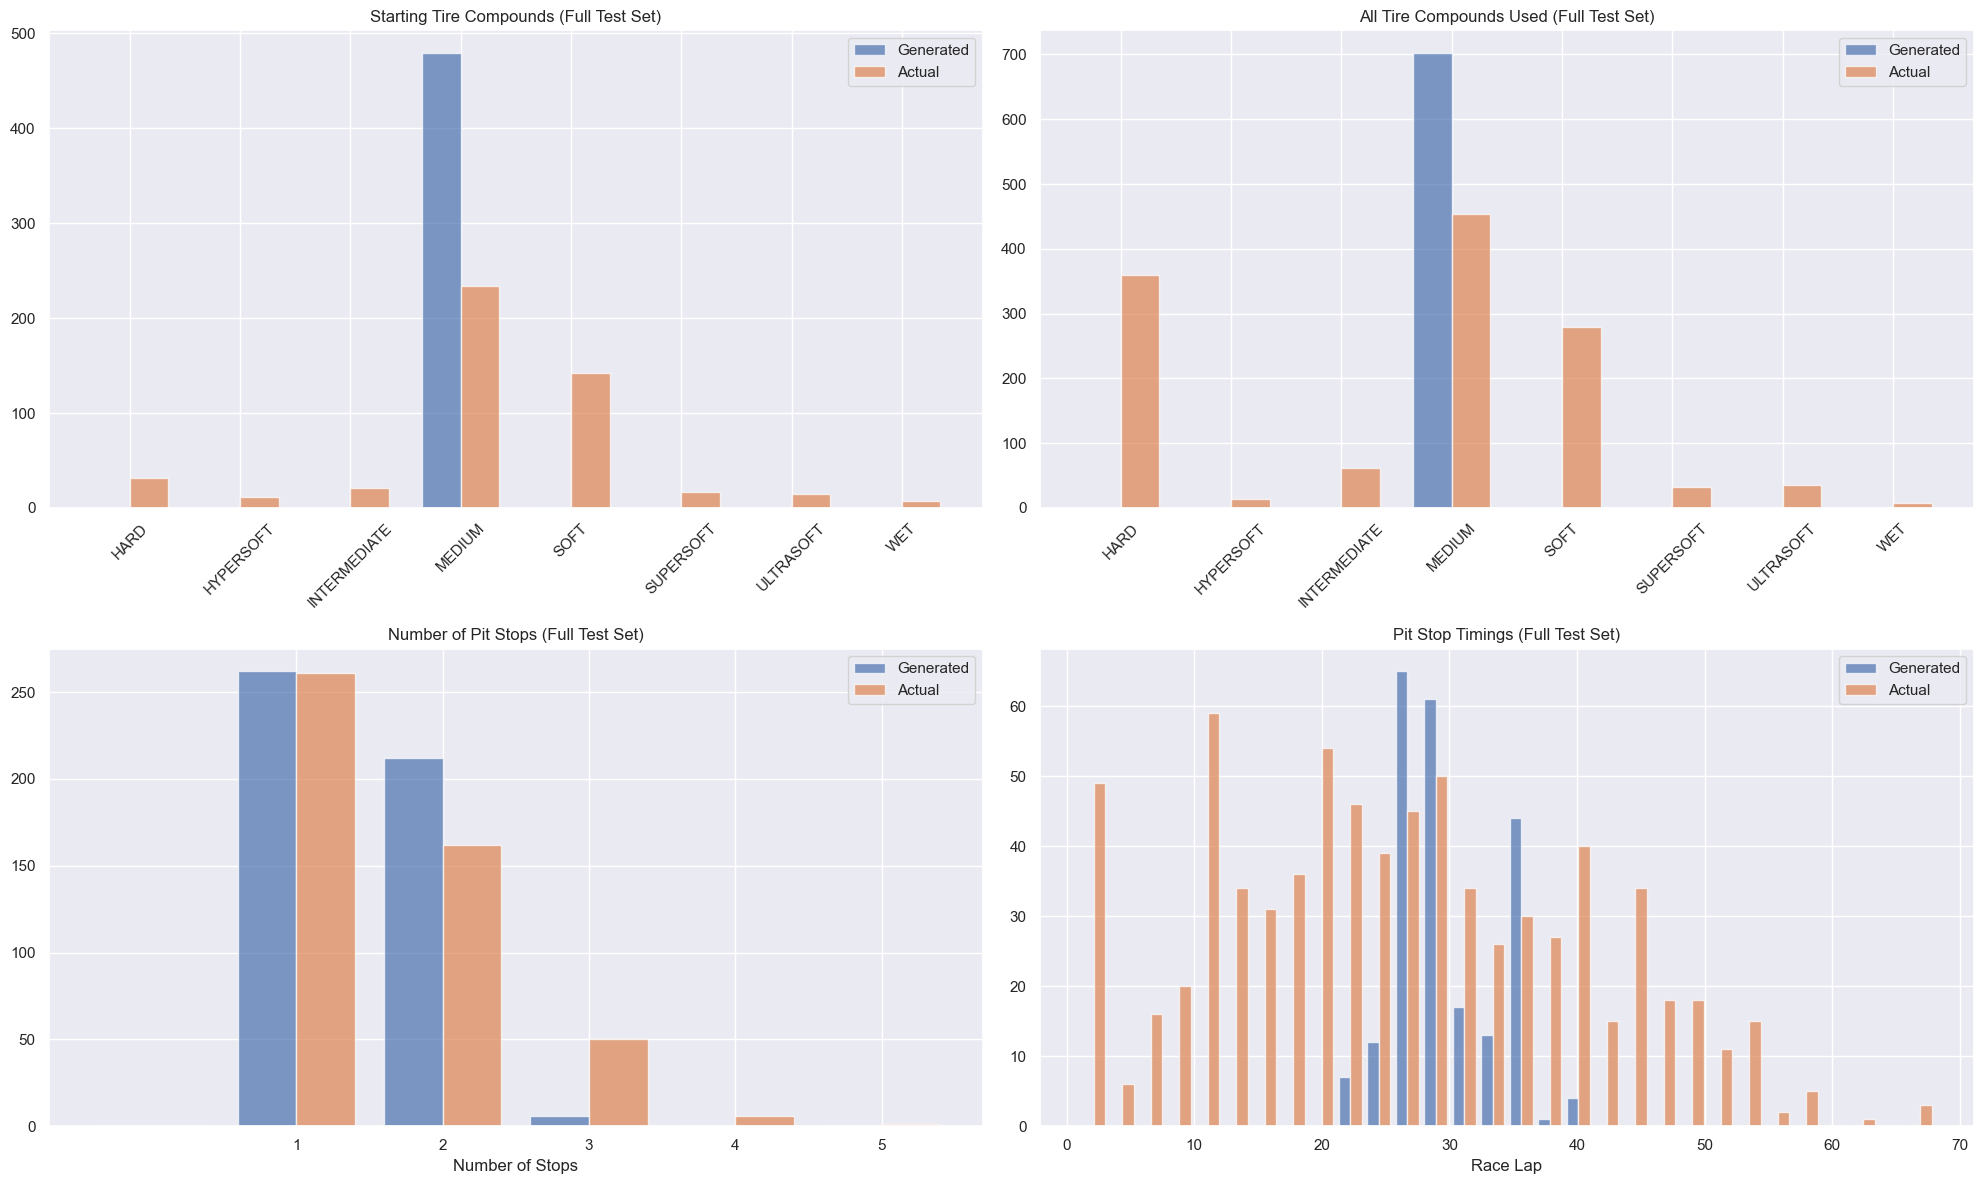


Overall Strategy Statistics (Full Test Set):
----------------------------------------
Total Races Analyzed: 480

Average Number of Stops:
Generated: 1.47
Actual: 1.59

Most Common Starting Compounds:
Generated:
- MEDIUM: 479
- SOFT: 1
- ULTRASOFT: 0

Actual:
- MEDIUM: 234
- SOFT: 142
- HARD: 32

Most Common Overall Compounds:
Generated:
- MEDIUM: 702
- SOFT: 2
- ULTRASOFT: 0

Actual:
- MEDIUM: 454
- HARD: 359
- SOFT: 280

Average Pit Stop Lap:
Generated: 30.0
Actual: 26.0


In [12]:
def test_strategy_generation(model, position_model, test_loader, device, num_examples=20):
    """Test strategy generation with comprehensive statistics"""
    model.eval()
    position_model.eval()
    
    test_dataset = test_loader.dataset
    feature_scaler = test_dataset.scaler
    pitstop_scaler = test_dataset.pitstop_scaler
    
    tyre_mappings = {
        0: "HARD",
        1: "HYPERSOFT",
        2: "INTERMEDIATE",
        3: "MEDIUM",
        4: "SOFT",
        5: "SUPERSOFT",
        6: "ULTRASOFT",
        7: "WET"
    }
    
    # Statistics containers for full test set
    all_generated_compounds_all = []
    all_actual_compounds_all = []
    all_generated_compounds_start = []
    all_actual_compounds_start = []
    all_generated_stops = []
    all_actual_stops = []
    all_generated_laps = []
    all_actual_laps = []
    
    print("\nStrategy Generation Tests")
    print("=" * 80)
    
    # First pass: collect statistics from full test set
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            try:
                batch = {k: v.to(device) for k, v in batch.items()}
                base_features = get_features_without_strategy(batch)
                
                strategy_outputs = model(
                    base_features['numerical_features'], 
                    base_features['categorical_features']
                )
                
                # Process each example in batch
                for i in range(batch['numerical_features'].size(0)):
                    # Get race laps
                    scaled_features = batch['numerical_features'][i].cpu().numpy().reshape(1, -1)
                    original_features = feature_scaler.inverse_transform(scaled_features)
                    race_laps = int(original_features[0, -1])
                    
                    # Get generated strategy details
                    num_stops = torch.argmax(strategy_outputs['num_pitstops_prob'][i:i+1], dim=1).item()
                    compounds = torch.argmax(strategy_outputs['tyre_compounds_prob'][i:i+1], dim=1).item()
                    timings = strategy_outputs['pitstop_laps_relative'][i] * race_laps
                    
                    # Process actual strategy
                    actual_num_stops = int(batch['pitstop_masks'][i].sum().item())
                    if actual_num_stops > 0:
                        actual_timings = process_pit_stop_laps(
                            batch['pitstop_laps'][i],
                            batch['pitstop_masks'][i],
                            pitstop_scaler,
                            race_laps
                        )
                    else:
                        actual_timings = []
                    
                    # Collect statistics
                    all_generated_compounds_start.append(compounds)
                    all_actual_compounds_start.append(batch['tyre_compounds'][i, 0].item())
                    
                    gen_compounds = [compounds] * (num_stops + 1)
                    actual_compounds = batch['tyre_compounds'][i, :actual_num_stops+1].cpu().numpy()
                    
                    all_generated_compounds_all.extend(gen_compounds)
                    all_actual_compounds_all.extend(actual_compounds.tolist())
                    
                    all_generated_stops.append(num_stops + 1)
                    all_actual_stops.append(actual_num_stops)
                    
                    if num_stops > 0:
                        generated_timings = timings[:num_stops].cpu().numpy()
                        generated_timings = np.clip(generated_timings, 1, race_laps-1)
                        all_generated_laps.extend(generated_timings)
                    
                    if len(actual_timings) > 0:
                        all_actual_laps.extend(actual_timings)
                        
            except Exception as e:
                print(f"Error collecting statistics from batch {batch_idx}: {str(e)}")
                continue
    
    # Second pass: print detailed examples
    example_count = 0
    for batch in test_loader:
        if example_count >= num_examples:
            break
        
        batch = {k: v.to(device) for k, v in batch.items()}
        base_features = get_features_without_strategy(batch)
        
        for i in range(batch['numerical_features'].size(0)):
            if example_count >= num_examples:
                break
                
            try:
                # Get race details
                scaled_features = batch['numerical_features'][i].cpu().numpy().reshape(1, -1)
                original_features = feature_scaler.inverse_transform(scaled_features)
                grid_pos = int(original_features[0, 1])
                race_laps = int(original_features[0, -1])
                
                print(f"\nRace {example_count + 1}")
                print("-" * 40)
                print(f"Starting Position: {grid_pos}")
                print(f"Race Distance: {race_laps} laps")
                
                # Generate strategy
                strategy_outputs = model(
                    base_features['numerical_features'][i:i+1], 
                    base_features['categorical_features'][i:i+1]
                )
                
                num_stops = torch.argmax(strategy_outputs['num_pitstops_prob'], dim=1).item()
                timings = strategy_outputs['pitstop_laps_relative'] * race_laps
                compounds = torch.argmax(strategy_outputs['tyre_compounds_prob'], dim=1).item()
                
                # Get actual strategy
                actual_num_stops = int(batch['pitstop_masks'][i].sum().item())
                
                # Print generated strategy
                print("\nGenerated Strategy:")
                print(f"Number of Stops: {num_stops + 1}")
                gen_compounds = [compounds] * (num_stops + 1)
                print("Complete Sequence:")
                print(f"Start: {tyre_mappings[gen_compounds[0]]}")
                
                generated_timings = timings[0, :num_stops].cpu().detach().numpy()
                generated_timings = np.clip(generated_timings, 1, race_laps-1)
                for j in range(num_stops):
                    print(f"Lap {int(generated_timings[j])}: {tyre_mappings[gen_compounds[j+1]]}")
                
                # Print actual strategy
                print("\nActual Strategy:")
                print(f"Number of Stops: {actual_num_stops}")
                actual_compounds = batch['tyre_compounds'][i, :actual_num_stops+1].cpu().numpy()
                print("Complete Sequence:")
                print(f"Start: {tyre_mappings[actual_compounds[0]]}")
                
                if actual_num_stops > 0:
                    actual_timings = process_pit_stop_laps(
                        batch['pitstop_laps'][i],
                        batch['pitstop_masks'][i],
                        pitstop_scaler,
                        race_laps
                    )
                    for j, lap in enumerate(actual_timings):
                        print(f"Lap {int(lap)}: {tyre_mappings[actual_compounds[j+1]]}")
                
                # Get position predictions
                timings_tensor = torch.tensor(generated_timings).unsqueeze(0).to(device)
                masks_tensor = torch.ones((1, num_stops), dtype=torch.bool, device=device)
                compounds_tensor = torch.tensor([compounds]).unsqueeze(1).expand(-1, 8).to(device)
                tyre_masks_tensor = torch.ones((1, num_stops + 1), dtype=torch.bool, device=device)

                generated_pos = position_model(
                    batch['numerical_features'][i:i+1],
                    batch['categorical_features'][i:i+1],
                    timings_tensor,
                    masks_tensor,
                    compounds_tensor,
                    tyre_masks_tensor
                )

                actual_pos = position_model(
                    batch['numerical_features'][i:i+1],
                    batch['categorical_features'][i:i+1],
                    batch['pitstop_laps'][i:i+1],
                    batch['pitstop_masks'][i:i+1],
                    batch['tyre_compounds'][i:i+1],
                    batch['tyre_masks'][i:i+1]
                )

                generated_change = generated_pos.item()
                actual_change = actual_pos.item()
                true_change = batch['target'][i].item()
                
                print("\nPosition Changes (positive means improvement):")
                print(f"Generated Strategy: {int(generated_change)}")
                print(f"Actual Strategy:    {int(actual_change)}")
                print(f"True Outcome:       {int(true_change)}")
                
                final_pos_gen = grid_pos - int(generated_change)
                final_pos_act = grid_pos - int(actual_change)
                final_pos_true = grid_pos - int(true_change)
                
                print(f"\nFinal Positions:")
                print(f'Grid Position {grid_pos}')
                print(f"Generated Strategy: {final_pos_gen}")
                print(f"Actual Strategy:    {final_pos_act}")
                print(f"True Outcome:       {final_pos_true}")
                
                print("-" * 80)
                example_count += 1
                
            except Exception as e:
                print(f"\nError processing example {example_count + 1}: {str(e)}")
                example_count += 1
                continue
    
    # Plot statistics
    _, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))
    
    # Starting tire compounds
    compound_names = list(tyre_mappings.values())
    gen_compound_counts_start = np.bincount(all_generated_compounds_start, minlength=len(tyre_mappings))
    act_compound_counts_start = np.bincount(all_actual_compounds_start, minlength=len(tyre_mappings))
    
    x = np.arange(len(tyre_mappings))
    width = 0.35
    
    ax1.bar(x - width/2, gen_compound_counts_start, width, label='Generated', alpha=0.7)
    ax1.bar(x + width/2, act_compound_counts_start, width, label='Actual', alpha=0.7)
    ax1.set_xticks(x)
    ax1.set_xticklabels(compound_names, rotation=45)
    ax1.set_title('Starting Tire Compounds (Full Test Set)')
    ax1.legend()
    
    # All tire compounds
    gen_compound_counts_all = np.bincount(all_generated_compounds_all, minlength=len(tyre_mappings))
    act_compound_counts_all = np.bincount(all_actual_compounds_all, minlength=len(tyre_mappings))
    
    ax2.bar(x - width/2, gen_compound_counts_all, width, label='Generated', alpha=0.7)
    ax2.bar(x + width/2, act_compound_counts_all, width, label='Actual', alpha=0.7)
    ax2.set_xticks(x)
    ax2.set_xticklabels(compound_names, rotation=45)
    ax2.set_title('All Tire Compounds Used (Full Test Set)')
    ax2.legend()
    
   # Number of pit stops
    max_stops = max(max(all_generated_stops), max(all_actual_stops))
    bins = np.arange(max_stops + 2) - 0.5  # Keep the bins the same

    ax3.hist([all_generated_stops, all_actual_stops], bins=bins, 
            label=['Generated', 'Actual'], alpha=0.7, rwidth=0.8)
    ax3.set_title('Number of Pit Stops (Full Test Set)')
    ax3.set_xlabel('Number of Stops')
    ax3.set_xticks(range(1, max_stops + 1))
    ax3.legend()
    
    # Pit stop timings
    ax4.hist([all_generated_laps, all_actual_laps], bins=30, label=['Generated', 'Actual'], 
             alpha=0.7)
    ax4.set_title('Pit Stop Timings (Full Test Set)')
    ax4.set_xlabel('Race Lap')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nOverall Strategy Statistics (Full Test Set):")
    print("-" * 40)
    print(f"Total Races Analyzed: {len(all_generated_stops)}")
    print("\nAverage Number of Stops:")
    print(f"Generated: {np.mean(all_generated_stops):.2f}")
    print(f"Actual: {np.mean(all_actual_stops):.2f}")
    
    print("\nMost Common Starting Compounds:")
    gen_top_compounds = np.argsort(gen_compound_counts_start)[-3:][::-1]
    act_top_compounds = np.argsort(act_compound_counts_start)[-3:][::-1]
    
    print("Generated:")
    for compound_idx in gen_top_compounds:
        print(f"- {tyre_mappings[compound_idx]}: {gen_compound_counts_start[compound_idx]}")
    
    print("\nActual:")
    for compound_idx in act_top_compounds:
        print(f"- {tyre_mappings[compound_idx]}: {act_compound_counts_start[compound_idx]}")
    
    print("\nMost Common Overall Compounds:")
    gen_top_compounds_all = np.argsort(gen_compound_counts_all)[-3:][::-1]
    act_top_compounds_all = np.argsort(act_compound_counts_all)[-3:][::-1]
    
    print("Generated:")
    for compound_idx in gen_top_compounds_all:
        print(f"- {tyre_mappings[compound_idx]}: {gen_compound_counts_all[compound_idx]}")
    
    print("\nActual:")
    for compound_idx in act_top_compounds_all:
        print(f"- {tyre_mappings[compound_idx]}: {act_compound_counts_all[compound_idx]}")
    
    if len(all_generated_laps) > 0 and len(all_actual_laps) > 0:
        print("\nAverage Pit Stop Lap:")
        print(f"Generated: {np.mean(all_generated_laps):.1f}")
        print(f"Actual: {np.mean(all_actual_laps):.1f}")

def process_pit_stop_laps(laps, mask, pitstop_scaler, race_laps):
    """Process pit stop laps to get actual lap numbers"""
    if torch.sum(mask) == 0:
        return []
        
    # Get valid pit stops
    valid_laps = laps[mask].cpu().numpy().reshape(-1, 1)
    
    # Unscale the laps
    unscaled_laps = pitstop_scaler.inverse_transform(valid_laps).flatten()
    
    # Clip to valid race lap range (1 to race_laps-1)
    # We use race_laps-1 as maximum because you can't pit on the last lap
    clipped_laps = np.clip(unscaled_laps, 1, race_laps-1)
    
    # Sort laps in ascending order
    sorted_laps = np.sort(clipped_laps)
    
    return sorted_laps

# Usage:
print("Testing strategy generator...")
test_strategy_generation(strategy_model, position_model, test_loader, device)

:::mermaid
%%{init: {'theme': 'base', 'themeVariables': { 'primaryColor': '#2f4050', 'primaryTextColor': '#fff' }}}%%
flowchart LR
    %% Input Features
    subgraph inputs["Input Features"]
        direction TB
        cat[/"Categorical Features
        Season, Circuit, Team, Driver"/]
        num[/"Numerical
        Features"/]
    end

    %% Feature Processing
    subgraph proc["Feature Processing"]
        direction TB
        %% Embeddings
        subgraph emb["Embeddings"]
            direction TB
            season_emb["Season Embedding
            128d + LayerNorm + Dropout"]
            circuit_emb["Circuit Embedding
            256d + LayerNorm + Dropout"]
            team_emb["Team Embedding
            192d + LayerNorm + Dropout"]
            driver_emb["Driver Embedding
            192d + LayerNorm + Dropout"]
        end

        %% Numerical Encoder
        num_enc["Numerical Encoder
        512 → 384 → 256
        LayerNorm, ReLU, Dropout"]
        
        %% Feature Combiner
        combiner["Feature Combiner
        1024d → 512d → 384d → 256d
        LayerNorm, ReLU, Dropout"]
    end

    %% Output Heads
    subgraph heads["Output Heads"]
        direction TB
        stops["Stops Head
        256d → 192d → 128d → 96d → 7 classes
        ReLU, Dropout"]
        timing["Timing Head
        256d → 384d → 256d → 128d → 7 values
        ReLU, Dropout, Sigmoid"]
        compound["Compound Head
        256d → 384d → 256d → 128d → 8 classes
        ReLU, Dropout"]
    end

    %% Connections
    cat --> emb
    num --> num_enc
    season_emb & circuit_emb & team_emb & driver_emb & num_enc --> combiner
    combiner --> stops
    combiner --> timing
    combiner --> compound

    %% Styling
    classDef default fill:#2f4050,stroke:#fff,color:#fff,stroke-width:2px
    classDef input fill:#34495e,stroke:#fff,color:#fff
    classDef dense fill:#2c3e50,stroke:#fff,color:#fff
    classDef seq fill:#283747,stroke:#fff,color:#fff
    class cat,num input
    class emb,num_enc,combiner dense
    class stops,timing,compound seq

| Component              | Parameter                            | Value                                       |
|------------------------|--------------------------------------|---------------------------------------------|
| **Input Features**     | Categorical Features                | Season, Circuit, Team, Driver               |
|                        | Numerical Features                  | Custom input dimension                     |
| **Embeddings**         | Season                              | 128d, LayerNorm, Dropout                   |
|                        | Circuit                             | 256d, LayerNorm, Dropout                   |
|                        | Team                                | 192d, LayerNorm, Dropout                   |
|                        | Driver                              | 192d, LayerNorm, Dropout                   |
| **Numerical Encoder**  | Layers                              | Input → 512d → 384d → 256d                 |
|                        | Processing                          | LayerNorm, ReLU, Dropout                   |
| **Feature Combiner**   | Input Dimension                     | 1024d (Numerical + Categorical)            |
|                        | Layers                              | 1024d → 512d → 384d → 256d                 |
|                        | Processing                          | LayerNorm, ReLU, Dropout                   |
| **Stops Head**         | Layers                              | 256d → 192d → 128d → 96d → 7 classes       |
|                        | Processing                          | ReLU, Dropout, Softmax                     |
| **Timing Head**        | Layers                              | 256d → 384d → 256d → 128d → 7 values       |
|                        | Processing                          | ReLU, Dropout, Sigmoid                     |
| **Compound Head**      | Layers                              | 256d → 384d → 256d → 128d → 8 classes      |
|                        | Processing                          | ReLU, Dropout                              |
| **Global Parameters**  | Dropout Rate                        | 0.2                                        |
|                        | Activation                          | ReLU                                       |
| **Outputs**            | Pit Stop Probabilities              | 7 classes                                  |
|                        | Pit Stop Lap Timings                | Normalized values                          |
|                        | Tyre Compound Probabilities         | 8 classes                                  |

| Parameter | Value | Description |
|-----------|-------|-------------|
| **Batch Size** | 64 | Training batch size |
| **Mixup** | Enabled | Alpha: 0.4 |
| **Stratified Sampling** | Enabled | Balanced data sampling |
| **Number of Epochs** | 100 | Total training iterations |
| **Optimizer** | AdamW | Adaptive optimization |
| **Learning Rate** | 1e-4 | Initial learning rate |
| **Weight Decay** | 0.05 | Regularization parameter |
| **Learning Rate Scheduler** | Cosine Annealing | Cyclic learning rate |
| **Min Learning Rate** | 1e-6 | Minimum scheduler rate |

| Loss Component | Weight | Description |
|---------------|--------|-------------|
| **Position Change** | 1.0 | Primary optimization objective |
| **Stint Length** | 0.4 | Penalizes unrealistic stint lengths |
| **Tire Diversity** | 0.3 | Encourages compound variation |
| **Pit Timing** | 0.3 | Ensures strategic pit stop placement |
| **Constraints** | - | Minimum stint: 1 lap |
| | - | Maximum stint: 60 laps |